In [11]:
from torch import optim
from torch.optim import Adam
from tqdm import tqdm

from utils.data import read_domain_ids_per_chain_from_txt
from utils.dataset import *
from utils.plot import *
from diffusion_model.embed import *
from diffusion_model.structure_diffusion_model import *

In [12]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 20
LEARNING_RATE = 1e-3

In [13]:
train_pdbs, train_pdb_chains = read_domain_ids_per_chain_from_txt('./data/train_domains.txt')
test_pdbs, test_pdb_chains = read_domain_ids_per_chain_from_txt('./data/test_domains.txt')

In [14]:
train_loader = BackboneCoordsDataLoader(train_pdb_chains, "./data/train_backbone_coords_20.npy", "./data/train_data_res_20.npy",seq_length=20, batch_size=128, shuffle=True)
test_loader = BackboneCoordsDataLoader(test_pdb_chains, './data/test_backbone_coords_20.npy', './data/test_data_res_20.npy', seq_length=20, batch_size=128, shuffle=True)

# Visualization of C alpha atoms

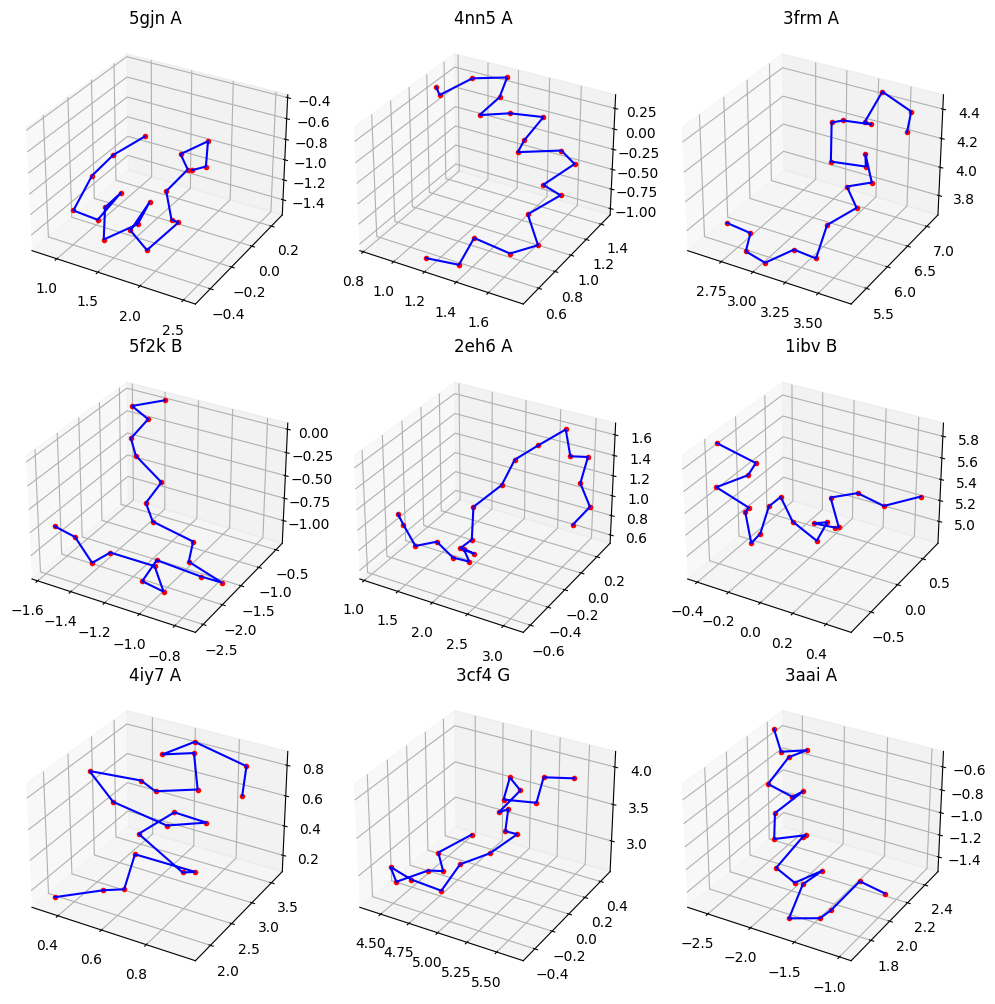

In [15]:
for batch_idx, (pdb_id, res, data) in enumerate(train_loader):
    ca_coords = data[:,:,1,:] #n, ca, c
    pdb_chain = [(x[:4], x[4]) for x in pdb_id]
    show_Calpha_plots(pdb_chain[:9], ca_coords[:9]) 
    break

# Visualization of forward diffusion process

PDB id:3v46 A


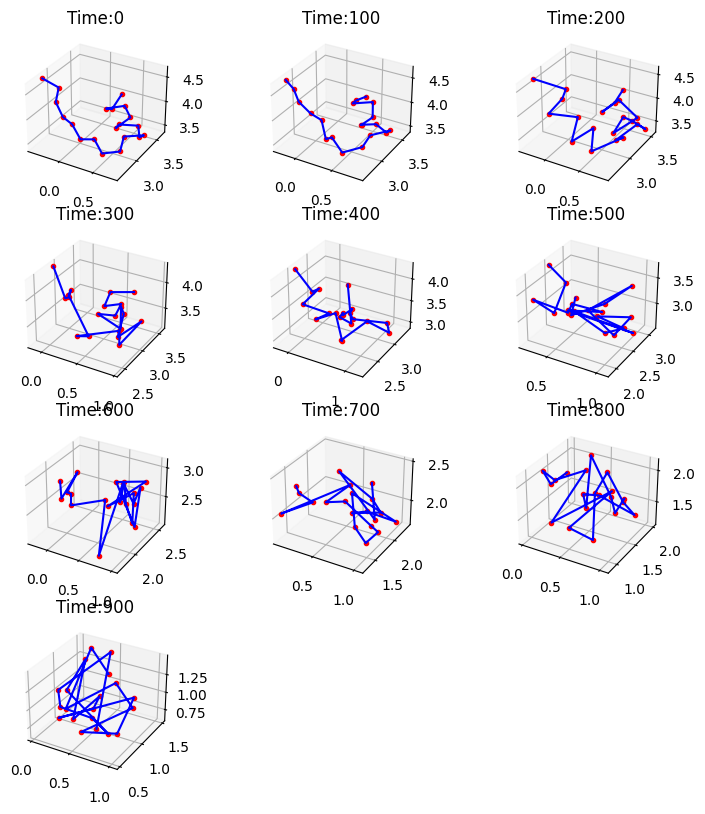

In [16]:
pdb_chain = next(iter(train_loader))[0][0]
atom_coords = next(iter(train_loader))[2][0]
ca_coords = atom_coords[:,1,:]
diffusion = ProteinDiffusion()
show_foward_diffusion(diffusion, pdb_chain, ca_coords, 1000)


In [17]:
diffusion = ProteinDiffusion(device=DEVICE)
model = StructureModel().to(DEVICE)
optimizer = optim.Adam(params=model.parameters(), lr = 1e-3)

In [18]:
for epoch in range(EPOCH):    
    model.train()
    train_loss = 0
    for batch_idx, (pdb, res_label, atom_coords) in enumerate(tqdm(train_loader, leave=False)):
        # Data preparation
        atom_coords = atom_coords.to(torch.float32)
        n_coords = atom_coords[:, :, 0]
        ca_coords = atom_coords[:, :, 1]
        c_coords = atom_coords[:, :, 2]
        R, t = rigidFrom3Points(n_coords, ca_coords, c_coords)
        q_0 = roma.rotmat_to_unitquat(R)
        single_repr = get_single_representation(pdb, res_label).to(DEVICE)
        
        pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(torch.float32)
        

        # Foward Diffusion
        batch_size = atom_coords.shape[0]
        time = diffusion.sample_timesteps(batch_size = batch_size)
        x_t = diffusion.coord_q_sample(ca_coords, time).to(torch.float32)
        q_t = diffusion.quaternion_q_sample(q_0, time)

        # train model
        pred_coords = model(single_repr, pair_repr.to(device=DEVICE), q_t.to(device=DEVICE), x_t.to(device=DEVICE))
        optimizer.zero_grad()
        loss = F.mse_loss(pred_coords, ca_coords.to(device=DEVICE))
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation
    print('====> Epoch: {} Average loss: {:.10f}'.format(epoch, train_loss / len(train_loader.dataset)))


====> Epoch: 0 Average loss: 11.4234711584


====> Epoch: 1 Average loss: 3.7378660643


====> Epoch: 2 Average loss: 2.2018617286


====> Epoch: 3 Average loss: 7.4472916042


====> Epoch: 4 Average loss: 0.0551075338


====> Epoch: 5 Average loss: 0.0329582748


====> Epoch: 6 Average loss: 0.0271129164


====> Epoch: 7 Average loss: 0.0257806350


====> Epoch: 8 Average loss: 0.0241099677


====> Epoch: 9 Average loss: 0.0230369325


====> Epoch: 10 Average loss: 0.0213468362


====> Epoch: 11 Average loss: 0.0215068851


====> Epoch: 12 Average loss: 0.0211914812


====> Epoch: 13 Average loss: 0.0206703182


====> Epoch: 14 Average loss: 0.0200523349


====> Epoch: 15 Average loss: 0.0197807396


====> Epoch: 16 Average loss: 0.0196874693


====> Epoch: 17 Average loss: 0.0197568238


====> Epoch: 18 Average loss: 0.0195666350


====> Epoch: 19 Average loss: 0.0201206092


In [20]:
# Save the model
torch.save(model.state_dict(), './trained_models/structure_model_20.pt')